# Image segmentaion with masked facies

Squish rectangular images to square

Using mask images processed in 01_02_mask_processing

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [103]:
import sys
from numbers import Integral
from random import uniform
from PIL import Image as pil_image
import fastai
from fastai.vision import *
from fastai.vision import Image
from fastai.vision.transform import _minus_epsilon
from fastai.vision.data import SegmentationProcessor
from fastai.vision.interpret import SegmentationInterpretation
from mask_functions import *
from collections import defaultdict
import cv2
from IPython.display import display 
import datetime
import uuid
from scipy.stats import mode

In [3]:
fastai.__version__

'1.0.60.dev0'

In [4]:
torch.cuda.set_device(0)

In [5]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')    

UID: b72ac331, DATE: 20191216


In [6]:
UID='2a1ae25a'
DATE='20191215'
NB='02_03'

In [7]:
SUBSET_DATA=False
SUBSET_LEN=171

In [8]:
tgt_height = 256
data_dir = Path('data')
train_images = data_dir/'train_images'
test_img = train_images/'mask_fill/test'

train_path = train_images/'mask_fill/train'
train_mask = train_path/'masks'
train_img = train_path/'images'


#subset
train_sub_path = train_images/'mask_fill/subset/train'
train_sub_mask = train_sub_path/'masks'
train_sub_img = train_sub_path/'images'

#train_path = train_sub_path
#train_mask = train_sub_mask
#train_img = train_sub_img


In [9]:
filename = 'data/CAX_LogFacies_Train_File.csv'

In [174]:
file_test = 'data/CAX_LogFacies_Test_File.csv'

#### all data

In [10]:
training_data = pd.read_csv(filename)
training_data.head()
training_data['well_file']='well_'+training_data['well_id'].astype(str)+'.png'
wells=training_data['well_file'].unique()
all_wells_df=pd.DataFrame(wells)
all_wells_df.head()
    
df_val = all_wells_df.sample(frac=0.2)
idx=df_val.index
df_trn=all_wells_df[~all_wells_df.index.isin(idx)]
assert len(df_val)+len(df_trn)==len(all_wells_df)
#df_val.to_csv(train_path/'val_20pct.csv', index=False, header=False)

In [176]:
test_df = pd.read_csv(file_test)
test_df.head()


,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


In [11]:
df_val.tail()

,0
1143,well_1143.png
545,well_545.png
665,well_665.png
1202,well_1202.png
950,well_950.png


#### Subset

In [12]:
df_val = pd.read_csv(train_images/'mask_fill/train/val_20pct.csv', names=["well_id"])
ids=range(0,SUBSET_LEN)
well_names=[]
for i in ids:
    well_names.append('well_'+str(i)+'.png')
df_sub_val=df_val.loc[df_val['well_id'].isin(well_names)]
#df_sub_val.to_csv(train_sub_path/'val_sub_20pct.csv', index=False, header=False)

In [13]:
df_val.head()

,well_id
0,well_87.png
1,well_154.png
2,well_3917.png
3,well_444.png
4,well_875.png


In [14]:
len(df_val)

800

### Data

In [15]:
train_img_names = get_image_files(train_img)
len(train_img_names)

4000

In [16]:
train_img_names[:3]

[PosixPath('data/train_images/mask_fill/train/images/well_2640.png'),
 PosixPath('data/train_images/mask_fill/train/images/well_2552.png'),
 PosixPath('data/train_images/mask_fill/train/images/well_1321.png')]

In [17]:
for im in train_img_names:
    assert 'crop' not in str(im)

In [18]:
train_mask_names = get_image_files(train_mask)
train_mask_names[:3]

[PosixPath('data/train_images/mask_fill/train/masks/well_2640.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_2552.png'),
 PosixPath('data/train_images/mask_fill/train/masks/well_1321.png')]

In [19]:
for im in train_mask_names:
    assert 'crop' not in str(im)

### Data QC

In [20]:
inames=[]
mnames=[]
for im in train_img_names:
    inames.append(im.name)
for im in train_mask_names:
    mnames.append(im.name)

In [21]:
train_img_names[0]

PosixPath('data/train_images/mask_fill/train/images/well_2640.png')

In [22]:
missing_i_m=set(inames) - set(mnames)

In [23]:
missing_m_i= set(mnames)-set(inames) 

In [24]:
assert len(missing_i_m)==len(missing_m_i)==0

In [25]:
len(inames)

4000

In [26]:
len(mnames)

4000

In [27]:
inames.sort()
mnames.sort()

In [28]:
len(inames)

4000

In [29]:
for im,mm in zip(inames, mnames):
    assert im==mm
    img=train_img/f'{im}'
    mmg=train_mask/f'{mm}'
    img_ =pil_image.open(img)
    mmg_ =pil_image.open(mmg)
    if img_.size != mmg_.size:
        print(f'img_.size: {img_.size} != mmg_.size: {mmg_.size}')

data/train_images/mask_fill/train/images/well_1770.png


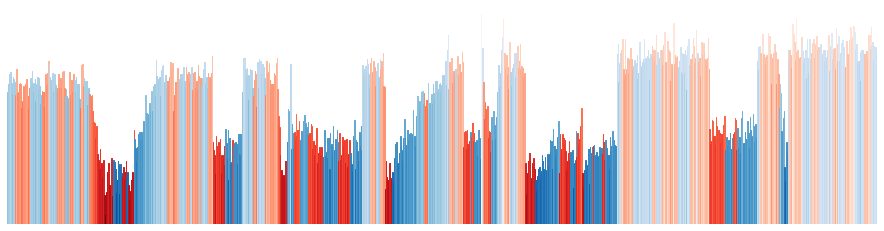

In [30]:
img_f = train_img_names[5]
print(img_f)
img_gr = open_image(img_f)
img_gr.show(figsize=(18,4))

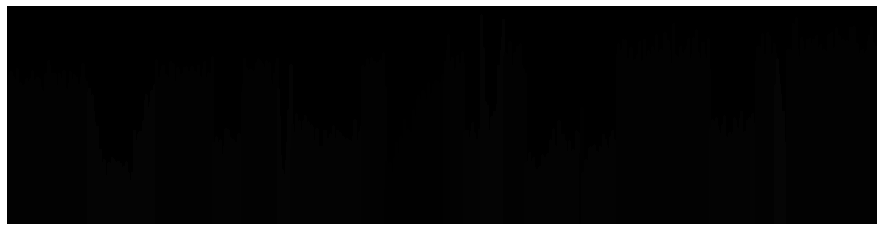

In [31]:
mask_f = train_mask_names[5]
mask_gr = open_image(mask_f)
mask_gr.show(figsize=(18,4))

### Link Masks with Images

In [32]:
get_y_fn = lambda x: train_mask/f'{x.stem}{x.suffix}' # converts from image to mask file name

In [33]:
get_y_fn(img_f)

PosixPath('data/train_images/mask_fill/train/masks/well_1770.png')

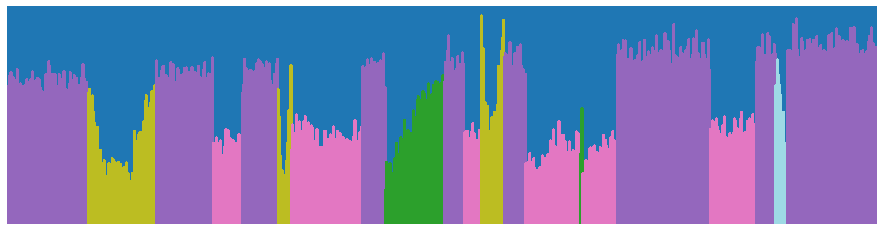

In [34]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(18,4), alpha=1)

In [35]:
u_values=[]
def get_all_uniques(images, subset=None):
    for i, im in enumerate(images):
        if subset and (i > subset):
            return u_values
        mask = np.asarray(pil_image.open(im))
        u_values.extend(np.unique(mask.tolist()))
    return u_values

In [36]:
#u_values=list(set(get_all_uniques(train_mask_names, 100)))
#u_values.sort()
#print(u_values)

Note that not all colours are mapped by fastai - we need to do this manually

### Log Facies

<pre>
            ▪ 0 (None), 
            ▪ 1 (Symmetrical), Hour glass (Prograding and retrograding)
            ▪ 2 (Cylindrical) Blocky sst (Aggrading)
            ▪ 3 (Funnel) Coarsening up (Prograding)
            ▪ 4 (Bell) Fining up (Retrograding)
</pre>



In [37]:
#codes = array(['Background', 'None', 'Symmetrical', 'Cylindrical', 'Funnel', 'Bell'])
codes = array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'])

In [38]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([ 275, 1100]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2],
          [2, 2, 2,  ..., 2, 2, 2]]]))

In [39]:
gr_size = np.array(img_gr.shape[1:])
gr_size,img_gr.data

(array([ 275, 1100]),
 tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.5843, 0.6392, 0.6980,  ..., 0.7961, 0.8235, 0.8000],
          [0.5843, 0.6392, 0.6980,  ..., 0.7961, 0.8235, 0.8000],
          [0.5843, 0.6392, 0.6980,  ..., 0.7961, 0.8235, 0.8000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.7725, 0.8000, 0.8235,  ..., 0.8706, 0.8902, 0.8745],
          [0.7725, 0.8000, 0.8235,  ..., 0.8706, 0.8902, 0.8745],
          [0.7725, 0.8000, 0.8235,  ..., 0.8706, 0.8902, 0.8745]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000,

### Segmentation masks

In [40]:
facies_rgb_list = [
    [255, 255, 255],
    [153, 102, 51],
    [0, 128, 0],
    [255, 0, 0],
    [0, 0, 255],
    [255, 255, 0]]

In [41]:
rgb_list = [
    [0, 0, 0],
    [1, 1, 1],
    [2, 2, 2],
    [3, 3, 3],
    [4, 4, 4],
    [5, 5, 5]]

In [42]:
def check_mask_conversion(fn:PathOrStr, div, convert_mode='RGB', after_open:Callable=None, rgb_list=[])->ImageSegment:
    '''Note we apply div after opening and conversion'''
    old_mask=open_image(fn, div=False, convert_mode=convert_mode, cls=ImageSegment, after_open=after_open)
    print(old_mask.data)
    assert True==False
    

In [43]:
def convert_mask(old_mask, rgb_list, div):
    '''
    create a bytemask for pixels = rgb value to be replaced, 
    sum over all columns
    fill in pixels with new idx value
    '''
    print(f'>>convert_mask(old_mask: {old_mask.data}')
    new_mask = torch.zeros((old_mask.shape[-2],old_mask.shape[-1]))
    for idx, rgb in enumerate(rgb_list):
        rgb_mask = torch.sum(old_mask.data.view((3,-1)).permute(1,0) == tensor(rgb),dim=1)==3 
        new_mask.masked_fill_(rgb_mask.view(new_mask.shape), tensor(idx)) 
    if div: 
        new_mask.div_(len(rgb_list))
    #print(f'new_mask: {new_mask.data}, max: {torch.max(new_mask)}, div: {div}, len(rgb_list): {len(rgb_list)}')
    return ImageSegment(new_mask.unsqueeze(0))

def open_mask_converted(fn:PathOrStr, div, convert_mode='RGB', after_open:Callable=None, rgb_list=rgb_list)->ImageSegment:
    '''Note we apply div after opening and conversion'''
    return convert_mask(open_image(fn, div=False, convert_mode=convert_mode, cls=ImageSegment, after_open=after_open), rgb_list, div=div)

In [44]:
class UniqueSegmentationLabelList(ImageList):
    "ItemList for segmentation masks"
    _processor=SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes,self.loss_func = classes,CrossEntropyFlat(axis=1)
    def open(self, fn): 
        return open_mask_converted(fn, div=False)
    def analyze_pred(self, pred, thresh:float=0.5): 
        return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): 
        return ImageSegment(t)

class UniqueSegmentationItemList(ImageList):
    _label_cls,_square_show_res = UniqueSegmentationLabelList,False

## Datasets

In [45]:
bs = 16
#size=src_size//2
#squish to square

size=(tgt_height, tgt_height)

In [46]:
tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0., max_zoom=1.1, max_lighting=0.0, \
                    max_warp=0., p_affine=0., p_lighting=0.0)

In [47]:
src = (SegmentationItemList.from_folder(path=train_img)
    .split_by_fname_file('../val_20pct.csv', path=train_img)
    .label_from_func(get_y_fn, classes=codes))

In [48]:
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [49]:
len(src.train.x)

3200

In [50]:
src_test = (SegmentationItemList.from_folder(path=train_img)
    .split_by_fname_file('../val_20pct.csv', path=train_img)
    .label_from_func(get_y_fn, classes=codes)
    .add_test_folder(test_folder='../../test', tfms=None, tfm_y=False))

In [51]:
data_test = (src_test.transform(size=size, tfms=None, tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [52]:
data.train_ds.x[0].shape

torch.Size([3, 275, 1100])

In [54]:
data_test.valid_ds.x[0].shape

torch.Size([3, 275, 1100])

In [ ]:
data.train_ds.y[0].shape

In [ ]:
uy=[]
def get_unique_y_vals(data_list):
    for yt in data_list:
        y=yt.data.numpy()
        uy.extend(np.unique(y.tolist()))
    return uy

In [ ]:
#u_values=list(set(get_unique_y_vals(data.train_ds.y)))
#u_values.sort()
#print(u_values)

In [ ]:
#y=data.train_ds.y[0].data.numpy()

In [ ]:
#np.unique(y)

In [ ]:
data.label_list

In [ ]:
data.show_batch(4, figsize=(10,7))

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### Model

Eval criterion:
    
Classification Accuracy (percentage of correctly predicted rows)

In [ ]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

def iou(input:Tensor, targs:Tensor) -> Rank0Tensor:
    "IoU coefficient metric for binary target."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input*targs).sum().float()
    union = (input+targs).sum().float()
    return intersect / (union-intersect+1.0)

In [56]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']
print(void_code)

def acc_camvid(input, target):
    #print(f'in: {input.shape}, tgt: {target.shape}')
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

0


In [ ]:
data

In [ ]:
wd=1e-2

In [ ]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd).to_fp16()

In [ ]:
learn.callback_fns

In [ ]:
#learn.loss_func=dice
learn.loss_func

In [ ]:
#learn.pred_batch()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-4

In [ ]:
learn.fit_one_cycle(1, slice(lr))

In [ ]:
learn.recorder.plot_losses()

### Save model

In [ ]:
#learn.save(f'{NB}-{UID}_unet_squish-s1-r0-{DATE}')

In [ ]:
#learn=learn.to_fp32()

In [ ]:
#learn.export(f'{NB}-{UID}_unet_squish-s1-r0-{DATE}.pkl')

In [ ]:
print(f'{NB}-{UID}_unet_squish-s1-r0-{DATE}')

### Loss QC

In [ ]:
learn.data.classes

In [ ]:
interp=SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs=interp.top_losses((128,128))

In [ ]:
top_losses, top_idxs

In [ ]:
top_losses.shape

In [ ]:
top_idxs.shape

In [ ]:
top_idxs[:20]

In [ ]:
tnp=top_idxs.numpy()
idxs=tnp[tnp<800]

In [ ]:
# show top loss
print(top_losses[idxs[0]])
interp.show_xyz(idxs[0], codes, sz=15)

In [ ]:
interp.show_xyz(idxs[3], codes, sz=15)

### Loss Distribution

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

In [ ]:
# single image class performance
i = 457
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

In [ ]:
# show xyz
interp.show_xyz(i)

### Inference

In [59]:
#wd=1e-2
#learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd).to_fp16()
#test_data = SegmentationItemList.from_folder(test_img)
learn=None

In [63]:
test_data = SegmentationItemList.from_folder(test_img)
learn = load_learner(path=train_img, file=f'{NB}-{UID}_unet_squish-s1-r0-{DATE}.pkl', test=test_data, tfm_y=False)

In [64]:
print(f'01_03-{UID}_unet_squish-s2-r0-{DATE}')

01_03-2a1ae25a_unet_squish-s2-r0-20191215


In [65]:
#learn = load_learner(path, fname=..., test=test_data)

In [66]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
#preds = (preds[:,1,...]>best_thr).long().numpy()
print(preds.sum())

tensor(1.3086e+08)


In [68]:
preds.shape

torch.Size([2000, 6, 256, 256])

In [69]:
preds[0].shape

torch.Size([6, 256, 256])

In [71]:
labels = np.argmax(preds, 1)

In [74]:
learn.data.classes

array(['Background', 'Funnel', 'None', 'Cylindrical', 'Symmetrical', 'Bell'], dtype='<U11')

In [72]:
len(labels)

2000

In [76]:
labels.shape

torch.Size([2000, 256, 256])

As a first pass we want the mode (most common) class for each column in the image

But we want to first ignore background

Lets check a single prediction first

Mult by 40 so can see different colours

In [98]:
npa=labels[0].numpy().astype(np.int32)*40

In [99]:
type(npa[0][0])

numpy.int32

In [100]:
img = pil_image.fromarray(npa)

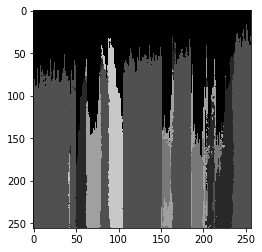

In [102]:
plt.imshow(img)

In [127]:
labels[0].shape

torch.Size([256, 256])

In [169]:
labels.shape

torch.Size([2000, 256, 256])

In [173]:
labels.shape[0]

2000

Example code for calculating median of columns in numpy array but ignoring 0 (background)

<pre>
n=np.array([[0,2,1], [0,1,3], [1,2,3]])
m_mask = n != 0  
new_m = np.where(m_mask, n, np.nan)
m=mode(new_m, axis=0)
r=m[0]
r=r[0].astype(int)
</pre>

In [177]:
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587


In [182]:
test_data.items

array([PosixPath('data/train_images/mask_fill/test/well_6076_GR.png'),
       PosixPath('data/train_images/mask_fill/test/well_5383_GR.png'),
       PosixPath('data/train_images/mask_fill/test/well_5135_GR.png'),
       PosixPath('data/train_images/mask_fill/test/well_6240_GR.png'), ...,
       PosixPath('data/train_images/mask_fill/test/well_5565_GR.png'),
       PosixPath('data/train_images/mask_fill/test/well_5580_GR.png'),
       PosixPath('data/train_images/mask_fill/test/well_5437_GR.png'),
       PosixPath('data/train_images/mask_fill/test/well_5667_GR.png')], dtype=object)

In [185]:
test_data

SegmentationItemList (2000 items)
Image (3, 390, 1528),Image (3, 390, 1528),Image (3, 390, 1528),Image (3, 390, 1528),Image (3, 390, 1528)
Path: data/train_images/mask_fill/test

In [189]:
def get_well_list(test_data):
    ids=[]
    for f in test_data:
        id=f.name.split('_')[1]
        ids.append(id)
    return ids

In [190]:
v=test_data.items.tolist()
well_ds=get_well_list(v)

In [238]:
len(well_ds)

int

In [237]:
labels.shape[0]

int

In [259]:
def calc_mean_on_cols(labels,well_ids):
    print(f'len(well_ids): {len(well_ids)}, labels.shape[0]: {labels.shape[0]}')
    frames=[]
    for i, id in enumerate(well_ids):
        row_ids=range(len(labels[i]))
        n=labels[i]
        m_mask = n != 0  
        new_m = np.where(m_mask, n, np.nan)
        m=mode(new_m, axis=0)
        r=m[0].flatten().astype(int)
        well_col=[id] * len(n)
        tdf = pd.DataFrame({'row_id': row_ids, 'facies': r,
                            'well_id': well_col})
        frames.append(tdf)
    df = pd.concat(frames)
    return df

In [260]:
df=calc_mean_on_cols(labels,well_ds)

len(well_ids): 2000, labels.shape[0]: 2000


In [261]:
len(df)

512000

In [263]:
df.tail()

,row_id,facies,well_id
251,251,2,5667
252,252,2,5667
253,253,2,5667
254,254,2,5667
255,255,2,5667


In [264]:
df = df.sort_values(by=['well_id', 'row_id'])

In [265]:
df.head()

,row_id,facies,well_id
0,0,2,5000
1,1,2,5000
2,2,2,5000
3,3,2,5000
4,4,2,5000
